## Logistic regression + SVM + Perceptron implementation

An ensemble of all three classifiers, take the majority from these three. 

In [ ]:
import numpy as np
from copy import copy
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Initializing paths + random seed

In [ ]:
# Initializing

np.random.seed(42)
TRAINING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_train_processed.csv'
TESTING_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_test_processed.csv'
EVAL_PATH = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/misc_eval_processed.csv'

TRAINING_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_train.csv'
TESTING_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_test.csv'
EVAL_PATH_GLOVE = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/glove_misc_eval.csv'

TRAINING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_train.csv'
TESTING_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_test.csv'
EVAL_PATH_TF = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/tf_misc_eval.csv'

TRAINING_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_train.csv'
TESTING_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_test.csv'
EVAL_PATH_BOW = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/processed_features/bow_misc_eval.csv'

EVAL_IDS = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/project_data/data/eval.ids'

## Data class

Plus some other helper functions

In [ ]:
# Defining Data class
# Will define new data class using csv and numpy

class Data:
  def __init__(self,file_path=None):
    if file_path != None:
      self.raw_data,\
      self.y,\
      self.X,\
      self.num_examples,\
      self.num_features = self.load_data_from_path(file_path)

  def load_data_from_path(self,file_path):
    # data = np.loadtxt(file_path, delimiter = ",")
    raw_data = pd.read_csv(file_path)
    data = raw_data.to_numpy()
    labels = data[:,0]
    instances = data[:,1:]

    # Add a 1 to the end of each instance
    bias = np.ones((data.shape[0],1))
    instances = np.append(instances,bias,axis=1)

    num_examples = data.shape[0]
    num_features = instances.shape[1]
    return data,labels,instances,num_examples,num_features

  def load_data(self,raw_data):
    self.raw_data = raw_data
    self.y = raw_data[:,0]
    instances = raw_data[:,1:]
    # Add a 1 to the end of each instance
    bias = np.ones((raw_data.shape[0],1))
    self.X = np.append(instances,bias,axis=1)
    self.num_examples = raw_data.shape[0]
    self.num_features = self.X.shape[1]

  def add_bias_to_features(self):
    # Add a 1 to the end of each instance
    bias = np.ones((self.num_examples,1))
    self.X = np.append(self.X,bias,axis=1)

  def add_data(self,data):
    # takes as input another data object and adds that data to this object
    self.raw_data = np.vstack((self.raw_data,data.raw_data))
    self.X = np.vstack((self.X,data.X))
    self.y = np.hstack((self.y,data.y))
    self.num_examples += data.num_examples

  # returns shuffled labels and instances
  def shuffle_data(self):
    shuffled_raw_data = np.copy(self.raw_data)
    np.random.shuffle(shuffled_raw_data)
    shuffled_labels = shuffled_raw_data[:,0]
    shuffled_instances = shuffled_raw_data[:,1:]
    # add in bias
    bias = np.ones((shuffled_raw_data.shape[0],1))
    shuffled_instances = np.append(shuffled_instances,bias,axis=1)

    return shuffled_instances,shuffled_labels


# plot learning curve
def plot_learning(x,y,title,x_label,y_label):
  # Let's plot
  plt.style.use('default')
  plt.rcParams['font.family'] = 'Avenir'
  plt.figure(figsize = (11,4.5))
  # My PCA
  plt.plot(x,y)
  plt.title(title,fontsize=15)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  [i.set_linewidth(0.4) for i in plt.gca().spines.values()]

## Logistic Regression class

In [ ]:
class LOGREG():
  def __init__(self):
    self.W = None
    self.Weights = {} # init empty dict of Weights, add to this for each epoch
    self.accuracies = {} # init empty dict of accuracies, which I store at end of each epoch
    self.loss = {} # dictionary contatining loss at each step
    self.num_updates = 0 # records number of updates made 

  def initialize_weights(self,num_features):
    # self.W = np.array([np.random.uniform(-0.01,0.01) for _ in range(num_features)])
    self.W = np.zeros((num_features)) # init to zeros
  
  def train(self,data,epochs=1,learning_rate=1,reg_strength=1):
    C = reg_strength
    epochs = epochs
    N = data.num_examples
    D = data.num_features
    # print("N:",N,"D (including b):",D)
    # initialize weights
    self.initialize_weights(D)
    
    for t in range(epochs):
      lr = learning_rate #/ (1 + t) # we use a decaying learning rate
      # shuffle data - doing this instead of random sampling, essentially same 
      # thing but is easier to keep track of epochs this way
      X,y = data.shuffle_data()
      # loop over each example in the training set
      for i in range(N):
        # compute gradient
        z = -y[i]*self.W.T.dot(X[i])
        dW = (np.exp(z)/(1.0 + np.exp(z)))*(-y[i]*X[i]) + (2.0/C)*self.W
        # dW = (sigmoid(self.W.T.dot(X[i]))-y[i])*X[i]
        # dW = (1-sigmoid(z))*(-y[i]*X[i]) + (2.0/C)*self.W
        # print("grad",dW)
        # update weights by stepping along gradient
        # Maybe this is my issue......
        # print(dW.shape)
        self.W = self.W - lr*(dW) 
      # store this iteration of weights 
      self.Weights[t] = self.W
      # store the accuracy of these weights
      self.accuracies[t] = self.get_accuracy_own_weights(data,self.W)
      # Compute and store the loss 
      self.loss[t] = self.compute_loss(data,self.W,C)


  # Helper methods for predicting and accuracy
  def get_best_weights_and_bias(self):
    # print(self.accuracies.items())
    best_epoch = max(self.accuracies,key=self.accuracies.get)
    # print("best epoch: ",best_epoch)
    return self.Weights[best_epoch],best_epoch

  def predict(self,data):
    predictions = np.sign(data.dot(self.W))
    return predictions

  def get_predict_accuracy(self,data):
    predictions = self.predict(data.X)
    equal = np.equal(predictions,data.y)
    return np.sum(equal)/data.num_examples

  def get_accuracy_own_weights(self,data,W):
    predictions = np.sign(data.X.dot(W)) # Should the prediction have a margin? No, I don't think so
    equal = np.equal(predictions,data.y)
    return np.sum(equal)/data.num_examples

  def compute_loss(self,data,W,C):
    # "Loss" of the entire dataset
    X = data.X
    y = data.y
    z = -y*W.dot(X.T)
    loss = np.sum(np.log(1+np.exp(z))) + (1/C)*W.T.dot(W)
    # print(loss)
    return loss


# sigmoid function
def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

## Load data

In [ ]:

# TF-IDF + Misc
train_data = Data(TRAINING_PATH_TF)
test_data = Data(TESTING_PATH_TF)

# Glove + Misc
# train_data = Data(TRAINING_PATH_GLOVE)
# test_data = Data(TESTING_PATH_GLOVE)

# BOW + Misc
# train_data = Data(TRAINING_PATH_BOW)
# test_data = Data(TESTING_PATH_BOW)

# Misc
# misc_train_data = Data(TRAINING_PATH)

## Initial training 

Try out some different lr and C's to get a feel for how log reg performs.

CPU times: user 1min 19s, sys: 15.3 s, total: 1min 34s
Wall time: 1min 7s
best training set accuracy:  0.7816
final test accuracy:  0.7902222222222223


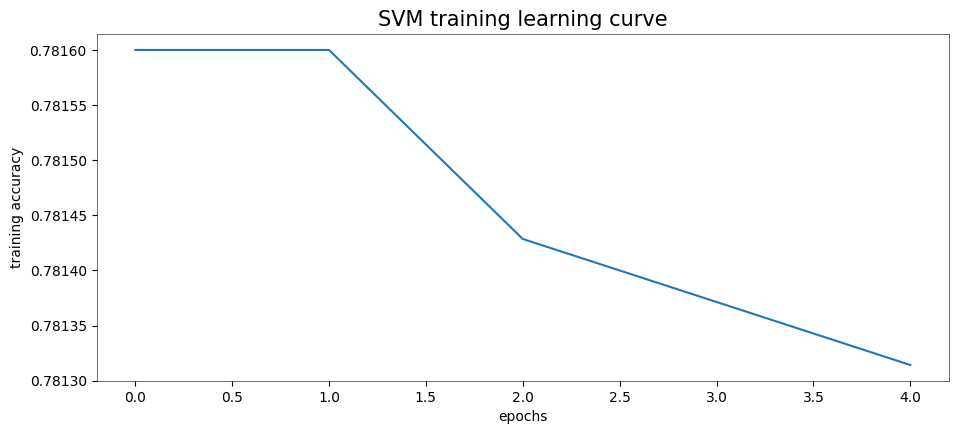

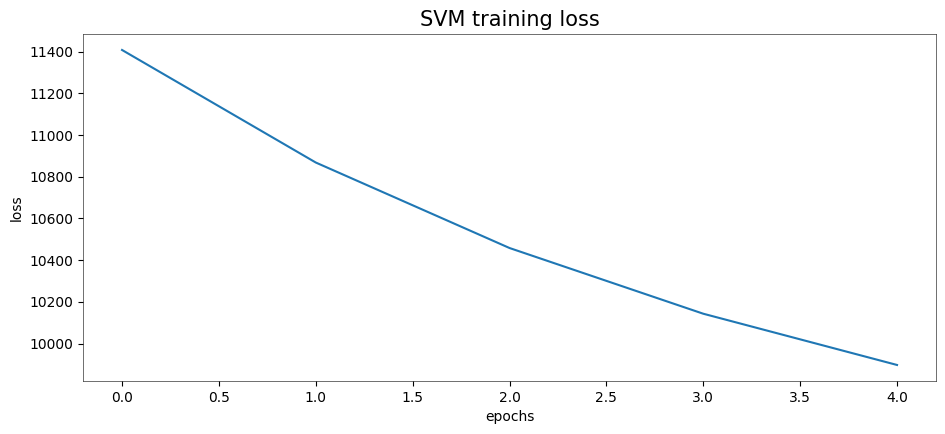

In [ ]:
learning_rate = 0.0001
C = 1000

epochs = 5
model = LOGREG()
%time model.train(train_data,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W,best_epoch = model.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", model.accuracies[best_epoch] )
# Use these weights and bias to evaluate on the test set
test_accuracy = model.get_accuracy_own_weights(test_data,W)
print("final test accuracy: ",test_accuracy)

y = list(model.accuracies.values())
x = [i for i in range(epochs)]
title = 'log reg training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(model.loss.values())
x = [i for i in range(epochs)]
title = 'log reg training loss'
plot_learning(x,y,title,'epochs','loss')

## Make cross validation folds

In [ ]:
# Validation splits - split training data into k splits

k = 3
folds = np.array_split(train_data.raw_data,k)

## Run cross validation

In [ ]:
def cross_validate(epochs,folds,learning_rates,regularizations,verbose=False,model=LOGREG()):

  # dictionaries storing accuracies corresponding to certain hyper parameter combinations
  mean_accuracies = {} 
  standard_deviations = {}

  num_combs = len(learning_rates)*len(regularizations)
  progress = 0
  
  for lr in tqdm(learning_rates):
    for C in tqdm(regularizations):
      accuracies = []
      # Need to concatenate 4 of the folds into one training set and leave out one as my test set
      for i in tqdm(range(k)):
        # Initialize new data objects
        val_data = Data()
        train_data = Data()
        folds_copy = list.copy(folds)
        # Set validation data
        val_data.load_data(np.array(folds_copy.pop(i)))
        # set training data
        train_data.load_data(np.concatenate(folds_copy,axis=0))
        # train on folds
        svm = model
        svm.train(train_data,epochs,lr,C)
        weights,best_epoch = svm.get_best_weights_and_bias()
        # calculate validation accuracy
        val_accuracy = svm.get_accuracy_own_weights(val_data,weights)
        accuracies.append(val_accuracy)

      mean_accuracies[(lr,C)] = np.mean(accuracies)
      standard_deviations[(lr,C)] = np.std(accuracies)
      if verbose == True:
        print("accuracy: ",mean_accuracies[(lr,C)],"lr: ",lr,"C: ",C)
        # print("list",accuracies)
        progress += 1
        print("{:.4}% complete".format(100*progress/num_combs))

  print(mean_accuracies.items())
  print(standard_deviations.items())
  best_vals = max(mean_accuracies,key=mean_accuracies.get)
  print("best lr: ",best_vals[0],"best C: ",best_vals[1],"cross-val accuracy: ",mean_accuracies[best_vals])
  return best_vals

In [ ]:
# cross validate 

epochs = 4
learning_rates = [10**0, 10**-1, 10**-2, 10**-4, 10**-5]
# learning_rates = [10**0, 10**-2, 10**-4]
# regularizations = [10**3, 10**2, 10**1, 10**0, 10**-1, 10**-2]
regularizations = [10**4, 10**3, 10**-1]

best_vals = cross_validate(epochs,folds,learning_rates,regularizations,verbose=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:44<01:28, 44.08s/it]

 67%|██████▋   | 2/3 [01:28<00:44, 44.25s/it]

100%|██████████| 3/3 [02:11<00:00, 43.92s/it]

 33%|███▎      | 1/3 [02:11<04:23, 131.77s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7880571382079857 lr:  1 C:  10000
6.667% complete




 33%|███▎      | 1/3 [00:44<01:28, 44.34s/it]

 67%|██████▋   | 2/3 [01:26<00:43, 43.80s/it]

100%|██████████| 3/3 [02:09<00:00, 43.06s/it]

 67%|██████▋   | 2/3 [04:20<02:11, 131.00s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7703999658494615 lr:  1 C:  1000
13.33% complete


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


 33%|███▎      | 1/3 [00:44<01:28, 44.18s/it]

 67%|██████▋   | 2/3 [01:26<00:43, 43.67s/it]

100%|██████████| 3/3 [02:08<00:00, 42.99s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.0 lr:  1 C:  0.1
20.0% complete




 33%|███▎      | 1/3 [00:43<01:27, 43.82s/it]

 67%|██████▋   | 2/3 [01:28<00:44, 44.08s/it]

100%|██████████| 3/3 [02:10<00:00, 43.66s/it]

 33%|███▎      | 1/3 [02:10<04:21, 130.99s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.8046859056523196 lr:  0.1 C:  10000
26.67% complete




 33%|███▎      | 1/3 [00:43<01:27, 43.51s/it]

 67%|██████▋   | 2/3 [01:25<00:43, 43.19s/it]

100%|██████████| 3/3 [02:08<00:00, 42.72s/it]

 67%|██████▋   | 2/3 [04:19<02:10, 130.15s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7889715153515899 lr:  0.1 C:  1000
33.33% complete




 33%|███▎      | 1/3 [00:43<01:27, 43.53s/it]

 67%|██████▋   | 2/3 [01:25<00:43, 43.21s/it]

100%|██████████| 3/3 [02:08<00:00, 42.99s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.0 lr:  0.1 C:  0.1
40.0% complete




 33%|███▎      | 1/3 [00:43<01:26, 43.31s/it]

 67%|██████▋   | 2/3 [01:25<00:42, 42.90s/it]

100%|██████████| 3/3 [02:07<00:00, 42.39s/it]

 33%|███▎      | 1/3 [02:07<04:14, 127.17s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7883429471840332 lr:  0.01 C:  10000
46.67% complete




 33%|███▎      | 1/3 [00:43<01:26, 43.22s/it]

 67%|██████▋   | 2/3 [01:24<00:42, 42.76s/it]

100%|██████████| 3/3 [02:06<00:00, 42.28s/it]

 67%|██████▋   | 2/3 [04:14<02:07, 127.07s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7872571414678812 lr:  0.01 C:  1000
53.33% complete




 33%|███▎      | 1/3 [00:45<01:30, 45.34s/it]

 67%|██████▋   | 2/3 [01:29<00:44, 44.93s/it]

100%|██████████| 3/3 [02:13<00:00, 44.39s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.6129716448070504 lr:  0.01 C:  0.1
60.0% complete




 33%|███▎      | 1/3 [00:43<01:27, 43.80s/it]

 67%|██████▋   | 2/3 [01:25<00:43, 43.26s/it]

100%|██████████| 3/3 [02:07<00:00, 42.64s/it]

 33%|███▎      | 1/3 [02:07<04:15, 127.92s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7814857455099594 lr:  0.0001 C:  10000
66.67% complete




 33%|███▎      | 1/3 [00:43<01:26, 43.22s/it]

 67%|██████▋   | 2/3 [01:25<00:42, 42.82s/it]

100%|██████████| 3/3 [02:07<00:00, 42.65s/it]

 67%|██████▋   | 2/3 [04:15<02:07, 127.93s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7817143104097845 lr:  0.0001 C:  1000
73.33% complete




 33%|███▎      | 1/3 [00:43<01:26, 43.43s/it]

 67%|██████▋   | 2/3 [01:25<00:43, 43.08s/it]

100%|██████████| 3/3 [02:08<00:00, 42.89s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7813142875513353 lr:  0.0001 C:  0.1
80.0% complete




 33%|███▎      | 1/3 [00:43<01:26, 43.45s/it]

 67%|██████▋   | 2/3 [01:25<00:42, 42.98s/it]

100%|██████████| 3/3 [02:07<00:00, 42.46s/it]

 33%|███▎      | 1/3 [02:07<04:14, 127.39s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7814857357146008 lr:  1e-05 C:  10000
86.67% complete




 33%|███▎      | 1/3 [00:43<01:27, 43.98s/it]

 67%|██████▋   | 2/3 [01:26<00:43, 43.64s/it]

100%|██████████| 3/3 [02:09<00:00, 43.01s/it]

 67%|██████▋   | 2/3 [04:16<02:07, 127.88s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

accuracy:  0.7816000181645132 lr:  1e-05 C:  1000
93.33% complete




 33%|███▎      | 1/3 [00:43<01:27, 43.54s/it]

 67%|██████▋   | 2/3 [01:25<00:43, 43.09s/it]

100%|██████████| 3/3 [02:07<00:00, 42.57s/it]

100%|██████████| 5/5 [32:14<00:00, 386.81s/it]

accuracy:  0.7816571544917901 lr:  1e-05 C:  0.1
100.0% complete
dict_items([((1, 10000), 0.7880571382079857), ((1, 1000), 0.7703999658494615), ((1, 0.1), 0.0), ((0.1, 10000), 0.8046859056523196), ((0.1, 1000), 0.7889715153515899), ((0.1, 0.1), 0.0), ((0.01, 10000), 0.7883429471840332), ((0.01, 1000), 0.7872571414678812), ((0.01, 0.1), 0.6129716448070504), ((0.0001, 10000), 0.7814857455099594), ((0.0001, 1000), 0.7817143104097845), ((0.0001, 0.1), 0.7813142875513353), ((1e-05, 10000), 0.7814857357146008), ((1e-05, 1000), 0.7816000181645132), ((1e-05, 0.1), 0.7816571544917901)])
dict_items([((1, 10000), 0.0027301936088277652), ((1, 1000), 0.011765814194703333), ((1, 0.1), 0.0), ((0.1, 10000), 0.0038294881454424778), ((0.1, 1000), 0.004266719797428695), ((0.1, 0.1), 0.0), ((0.01, 10000), 0.0025015057724584087), ((0.01, 1000), 0.0018198061384544413), ((0.01, 0.1), 0.08871695699998539), ((0.0001, 10000), 0.000799463352465202), ((0.0001, 1000), 0.000763700127013021), ((0.0001, 0.1), 0.00063

This cross val gave me:  

best lr:  0.1 best C:  10000 cross-val accuracy:  0.8046859056523196

findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


CPU times: user 4min 36s, sys: 55.1 s, total: 5min 31s
Wall time: 4min 1s
best training set accuracy:  0.8393714285714285
final test accuracy:  0.8284444444444444


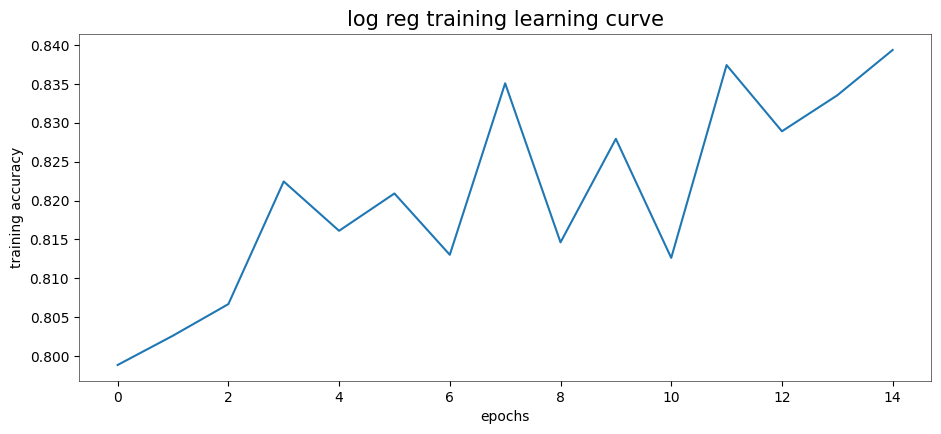

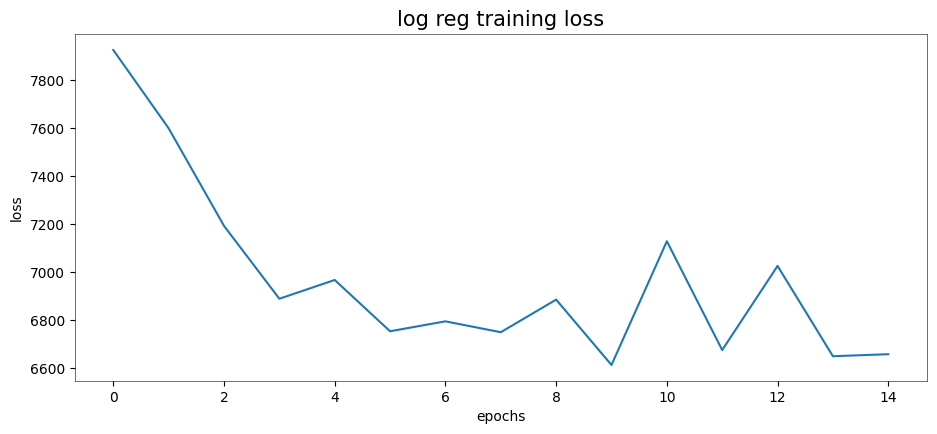

In [ ]:
learning_rate = 0.1
C = 10000

epochs = 15
model = LOGREG()
%time model.train(train_data,epochs,learning_rate,C)

# test set accuracy
# Get the best weights and bias from this training
W,best_epoch = model.get_best_weights_and_bias()
# training set accuracy:
print("best training set accuracy: ", model.accuracies[best_epoch] )
# Use these weights and bias to evaluate on the test set
test_accuracy = model.get_accuracy_own_weights(test_data,W)
print("final test accuracy: ",test_accuracy)

y = list(model.accuracies.values())
x = [i for i in range(epochs)]
title = 'log reg training learning curve'
plot_learning(x,y,title,'epochs','training accuracy')

y = list(model.loss.values())
x = [i for i in range(epochs)]
title = 'log reg training loss'
plot_learning(x,y,title,'epochs','loss')

Save best weights

In [ ]:
outfile = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/logreg_weights.npy'
np.save(outfile, W)

## Load weights from previous models (SVM & perceptron)

In [ ]:
# Load weights and bias from perceptron
W_perc = np.load('/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/ensemble implementation/perceptron_weights.npy')
b_perc = np.load('/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/ensemble implementation/perceptron_bias.npy')

# load weights from svm
W_svm = np.load('/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/ensemble implementation/svm_weights.npy')

# load log reg weights
W_logreg = np.load('/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/ensemble implementation/logreg_weights.npy')


## Evaluate ensemble on test set

Essentially I'll make a prediction on each example using each model and return the majority prediction.

In [ ]:
# remove last feature of X for perceptron (bias wasn't included)
X_perc = test_data.X[:,:-1]

# perceptron predictions
perc_preds = np.sign(X_perc.dot(W_perc) + b_perc)

# SVM predictions
svm_preds = np.sign(test_data.X.dot(W_svm))

# logistic regression predictions
log_preds = np.sign(test_data.X.dot(W_logreg))


I can get the predicted label by adding these and taking the sign

In [ ]:
preds = np.sign(perc_preds + svm_preds + log_preds)

print(perc_preds[0:20])
print(svm_preds[0:20])
print(log_preds[0:20])
print(preds[0:20])

[-1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.
 -1.  1.]
[-1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.
 -1.  1.]
[-1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.
 -1.  1.]
[-1.  1. -1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.
 -1.  1.]


In [ ]:
# Get accuracy
equal = np.equal(preds,test_data.y)
acc = np.sum(equal)/test_data.num_examples
print("ensemble test acc: ",acc)

ensemble test acc:  0.8488888888888889


Hmmmmm.... It's ok... but not great. It looks to be exactly the same accuracy as my perceptron. I think in order to improve this I would need to improve my feature set... which I could do with either some thoughtful tweaking of my features by hand... or use neural nets! I'll do neural nets.

## Run ensemble on eval data

In [ ]:
# load eval data
eval_data = Data(EVAL_PATH_TF)

In [ ]:
# eval ids
def load_ids(file_path):
  with open(file_path) as f:
    raw_data = [int(line.split()[0]) for line in f]
  # print(raw_data)
  return raw_data

eval_ids = np.reshape(np.array(load_ids(EVAL_IDS),dtype=np.int32),(eval_data.X.shape[0],1))
# print(eval_ids)

# remove last feature of X for perceptron (bias wasn't included)
X_perc = eval_data.X[:,:-1]

# perceptron predictions
perc_preds = np.sign(X_perc.dot(W_perc) + b_perc)

# SVM predictions
svm_preds = np.sign(eval_data.X.dot(W_svm))

# logistic regression predictions
log_preds = np.sign(eval_data.X.dot(W_logreg))

predictions = np.sign(perc_preds + svm_preds + log_preds)


predictions[predictions == -1] = 0
predictions = np.reshape(predictions,(eval_data.X.shape[0],1))
print(predictions.shape)
print(predictions)
eval_out = np.hstack((eval_ids,predictions))
print(eval_out.shape)
print(eval_out)
eval_df = pd.DataFrame(data = eval_out,index = None,columns=['example_id','label'])
save_to_path = '/content/drive/My Drive/Colab Notebooks/Machine Learning 2020/old-bailey-decisions/ensemble_evals.csv'
eval_df.to_csv(path_or_buf=save_to_path,index=False)

(5250, 1)
[[1.]
 [0.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]]
(5250, 2)
[[0.000e+00 1.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 1.000e+00]
 ...
 [5.247e+03 1.000e+00]
 [5.248e+03 0.000e+00]
 [5.249e+03 0.000e+00]]
